In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from re import sub
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder, StandardScaler, RobustScaler

from sklearn.decomposition import PCA

from prince import FAMD


In [21]:
train_df=pd.read_csv("../dataset/train.csv")
test_df=pd.read_csv("../dataset/test.csv")
data = pd.concat([train_df, test_df], ignore_index=True)
data.head()


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [22]:
data = data.drop(data.iloc[:, [0,1]], axis=1)


In [23]:
data.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

In [24]:
data["Arrival Delay in Minutes"].fillna(0,inplace=True)

/var/folders/2s/q86v619s3_g1crpyjj20lc9m0000gn/T/ipykernel_92003/3760461088.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Arrival Delay in Minutes"].fillna(0,inplace=True)


In [25]:
# Replace spaces with underscores in column names
feature_names = data.columns.tolist()
data.columns = [sub(r'\s+', '_', col.strip()) for col in data.columns]


# Encode categorical variables, to avoid the dummy variable we will appply
#  - OrdinalEncoder() for non-hierarhical features
#  - LabelEncoder() for hierarchical features

In [26]:
#extract categorical variables into "cat_vars" dataframe
cat_vars = data.select_dtypes(include=['object']).copy()
cat_vars_names = cat_vars.columns

In [27]:
for i in cat_vars_names:
    temp=str(pd.unique(cat_vars[i]))
    print(f"{i:<15}{temp:<30}")

Gender         ['Male' 'Female']             
Customer_Type  ['Loyal Customer' 'disloyal Customer']
Type_of_Travel ['Personal Travel' 'Business travel']
Class          ['Eco Plus' 'Business' 'Eco'] 
satisfaction   ['neutral or dissatisfied' 'satisfied']


Only "Class" variable contains ordered values and therefore must be transformed with the OrdinalEncoder().

In [28]:
class_lvls=["Eco","Eco Plus","Business"]
enc=OrdinalEncoder(categories=[class_lvls])
cat_vars["Class"]=enc.fit_transform(cat_vars[["Class"]]) 
cat_vars["Class"]=pd.to_numeric(cat_vars["Class"],downcast="integer") # float -> int
cat_vars["Class"].head()

0    1
1    2
2    2
3    2
4    2
Name: Class, dtype: int8

In [29]:
rate_vars = data.iloc[: ,6: 20].copy()
rate_vars

,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness
0,3,4,3,1,5,3,5,5,4,3,4,4,5,5
1,3,2,3,3,1,3,1,1,1,5,3,1,4,1
2,2,2,2,2,5,5,5,5,4,3,4,4,4,5
3,2,5,5,5,2,2,2,2,2,5,3,1,4,2
4,3,3,3,3,4,5,5,3,3,4,4,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,3,3,3,1,4,3,4,4,3,2,4,4,5,4
129876,4,4,4,4,4,4,4,4,4,5,5,5,5,4
129877,2,5,1,5,2,1,2,2,4,3,4,5,4,2
129878,3,3,3,3,4,4,4,4,3,2,5,4,5,4


Label encoding 
For binominal variables, an order of values does not matter, regarding encoding. Thus, apply the LabelEncoder() to the "Gender", "Customer_Type", "Type_of_Travel" and "satisfaction" variables:

In [30]:
lab_enc_vars=cat_vars_names.drop("Class")
for i in lab_enc_vars:
    le=LabelEncoder()
    cat_vars[i]=le.fit_transform(cat_vars[i])

cat_vars.head()

,Gender,Customer_Type,Type_of_Travel,Class,satisfaction
0,1,0,1,1,0
1,1,1,0,2,0
2,0,0,0,2,1
3,0,0,0,2,0
4,1,0,0,2,1


Scale numerical variables 
First, create a subset containing only numerical variables and take a look at them.

All the variables in "num_vars" can be virtually divided into 2 groups:

passenger/flight metrics:
Age,
Flight_Distance,
Departure_Delay_in_Minutes,
Arrival_Delay_in_Minutes.
The variables can be scaled with the Robust Scaler.

Finally, we scale the four variables and save them into "num_scaled" dataframe.

In [ ]:
num_vars=data[["Age", "Flight_Distance", "Departure_Delay_in_Minutes", "Arrival_Delay_in_Minutes"]].copy()
num_scaled=StandardScaler().fit_transform(num_vars)
num_scaled=pd.DataFrame(num_scaled,columns=num_vars.columns)
num_scaled.head()

In [32]:
final_df = pd.concat([cat_vars, rate_vars, num_scaled], axis=1)
final_df.head()

,Gender,Customer_Type,Type_of_Travel,Class,satisfaction,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,...,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Age,Flight_Distance,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
0,1,0,1,1,0,3,4,3,1,5,...,4,3,4,4,5,5,-1.747961,-0.732184,0.270187,0.076909
1,1,1,0,2,0,3,2,3,3,1,...,1,5,3,1,4,1,-0.954274,-0.957760,-0.360214,-0.235460
2,0,0,0,2,1,2,2,2,2,5,...,4,3,4,4,4,5,-0.888133,-0.048440,-0.386481,-0.391644
3,0,0,0,2,0,2,5,5,5,2,...,2,5,3,1,4,2,-0.954274,-0.629924,-0.097547,-0.157368
4,1,0,0,2,1,3,3,3,3,4,...,3,4,4,3,3,3,1.426788,-0.978814,-0.386481,-0.391644


In [33]:
mixed_df = pd.concat([cat_vars, rate_vars, num_scaled], axis=1)
print(mixed_df.head())
X_mixed = mixed_df.drop(columns='satisfaction')
y = mixed_df['satisfaction']

famd_model = FAMD(n_components=2, random_state=42, engine='sklearn', handle_unknown="error")
famd_components = famd_model.fit_transform(X_mixed)

famd_projection = pd.DataFrame(
    famd_components.to_numpy(),
    columns=['Dim1', 'Dim2'],
    index=X_mixed.index
)
famd_projection = pd.concat([famd_projection, y.reset_index(drop=True)], axis=1)
famd_projection.head()


   Gender  Customer_Type  Type_of_Travel  Class  satisfaction  \
0       1              0               1      1             0   
1       1              1               0      2             0   
2       0              0               0      2             1   
3       0              0               0      2             0   
4       1              0               0      2             1   

   Inflight_wifi_service  Departure/Arrival_time_convenient  \
0                      3                                  4   
1                      3                                  2   
2                      2                                  2   
3                      2                                  5   
4                      3                                  3   

   Ease_of_Online_booking  Gate_location  Food_and_drink  ...  \
0                       3              1               5  ...   
1                       3              3               1  ...   
2                       2          

,Dim1,Dim2,satisfaction
0,-3.356892,1.051026,0
1,9.520199,10.642744,0
2,-6.232281,-2.099183,1
3,4.288877,-11.042112,0
4,-1.241786,-1.639628,1


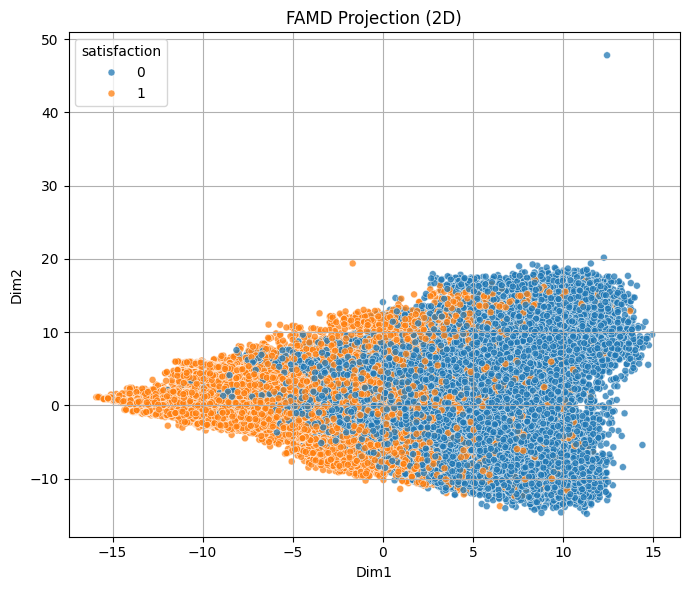

In [34]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=famd_projection,
    x='Dim1',
    y='Dim2',
    hue='satisfaction',
    s=25,
    alpha=0.75
)
plt.xlabel('Dim1')
plt.ylabel('Dim2')
plt.title('FAMD Projection (2D)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
explained_inertia = famd_model.eigenvalues_ / famd_model.total_inertia_
pd.Series(
    explained_inertia * 100,
    index=[f'Dim{i+1}' for i in range(len(explained_inertia))],
    name='Explained Inertia (%)'
)


Dim1    5.687208
Dim2    4.262298
Name: Explained Inertia (%), dtype: float64

In [36]:
famd_model.column_contributions_.loc[:, [0, 1]].sort_values(by=0, ascending=False).head(10)
famd_model.column_contributions_.style.format('{:.0%}')


component,0,1
variable,,
Age,0%,0%
Flight_Distance,0%,0%
Departure_Delay_in_Minutes,0%,0%
Arrival_Delay_in_Minutes,0%,0%
Baggage_handling,1%,0%
Checkin_service,0%,0%
Class,1%,0%
Cleanliness,1%,2%
Customer_Type,0%,0%


In [37]:
famd_model.row_contributions_.head()
(
    famd_model.row_contributions_
    .sort_values(0, ascending=False)
    .head(5)
    .style.format('{:.3%}')
)


component,0,1
6580,0.012%,0.137%
21845,0.005%,0.000%
17786,0.005%,0.000%
72581,0.005%,0.000%
80436,0.005%,0.000%
